In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from numpy.random import seed


In [527]:
#Read data
gdp_data=pd.read_excel("API_NY.GDP.MKTP.CD_DS2_en_excel_v2_6553527 - Copy.xls",sheet_name="Data")
diesel_demand=pd.read_excel("Petrolem Demand.xlsx",sheet_name="Diesel_Finalized")
petrol_demand=pd.read_excel("Petrolem Demand.xlsx",sheet_name="Petrol_Finalized")
gas_demand=pd.read_excel("Petrolem Demand.xlsx",sheet_name="LPG_Finalized")

In [528]:
diesel_demand.columns=diesel_demand.iloc[0]
diesel_demand.drop(index=0,axis=0,inplace=True)

gas_demand.columns=gas_demand.iloc[0]
gas_demand.drop(index=0,axis=0,inplace=True)

petrol_demand.columns=petrol_demand.iloc[0]
petrol_demand.drop(index=0,axis=0,inplace=True)

In [529]:
gdp_data.columns=gdp_data.iloc[2]
gdp_data.drop(index=[0,1,2],axis=0,inplace=True)

In [530]:

zwe_gdp=gdp_data[gdp_data['Country Code']=="ZWE"]
zwe_gdp=zwe_gdp.drop(columns=['Country Name',   'Country Code', 'Indicator Name', 'Indicator Code',
                 1960.0,           1961.0,           1962.0,           1963.0,
                 1964.0,           1965.0,           1966.0,           1967.0,
                 1968.0,           1969.0,           1970.0,           1971.0,
                 1972.0,           1973.0,           1974.0,           1975.0,
                 1976.0,           1977.0,           1978.0,           1979.0,
                 1980.0,           1981.0,           1982.0,           1983.0,
                 1984.0,           1985.0,           1986.0,           1987.0,
                 1988.0,           1989.0,           1990.0,           1991.0,
                 1992.0,           1993.0,           1994.0,           1995.0,
                 1996.0,           1997.0,           1998.0,           1999.0,
                 2000.0,           2001.0,           2002.0,           2003.0,
                 2004.0,           2005.0,           2006.0,           2007.0,
                 2008.0],axis=1)


In [531]:
zwe_gdp[2023]=np.mean(np.array(zwe_gdp))

In [532]:
def get_data(data,product,_data=pd.DataFrame({'Date':[],"Product":[],"GDP":[],"Sales":[]})):
    cols=data['Year']
    for year in cols:
        demand=data[data['Year']==year]
        if year!='Grand Total':
            for month in demand.columns:
                if (month != "Year" )and (month != "Grand Total"):
                    new_row={'Date':f"01 {month} {year}","Product":product,"GDP":zwe_gdp[int(year)].values[0],'Sales':demand[month].values[0]}
                    _data.loc[len(_data)] = new_row
    return _data


data=get_data(diesel_demand,"Diesel")
data=get_data(gas_demand,"Gas",data)
data=get_data(petrol_demand,"Petrol_demand",data)


In [533]:
data['Product']=data['Product'].astype('category').cat.codes


In [534]:
X=data.iloc[:,:-1]
Y=data.iloc[:,-1]

In [535]:
data['Date']= pd.to_numeric(pd.to_datetime(data['Date']))
# diesel_demand['Date']=pd.to_numeric(pd.to_datetime(diesel_demand['Date']))
# petrol_demand['Date']=pd.to_numeric(pd.to_datetime(petrol_demand['Date']))

In [536]:
X=data.iloc[:,:-1]
Y=data.iloc[:,-1]

Y=np.array(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [537]:
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)
lr_predict=lr_model.predict(x_test)
r2_score(y_test,lr_predict)

-0.034217640644278235

In [538]:
svr_model=SVR()
svr_model.fit(x_train,y_train)
svr_predict=svr_model.predict(x_test)
r2_score(y_test,svr_predict)

-0.02075849774306926

In [539]:
best_rscore=0
for i in range(1,700,30):
    random_forest_model=RandomForestRegressor(n_estimators=i,criterion="poisson")
    random_forest_model.fit(x_train,y_train)
    random_forest_predict=random_forest_model.predict(x_test)
    score= r2_score(y_test,random_forest_predict)
    if score>best_rscore:
        best_rscore=score

best_rscore

0.8450529727857792

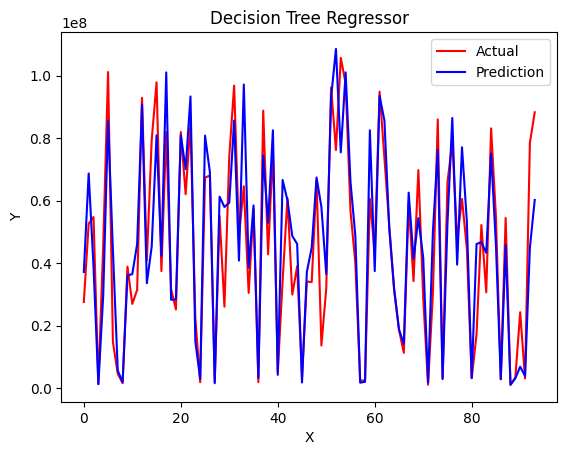

0.7787318429306206

In [540]:
decision_tree_model=DecisionTreeRegressor()
decision_tree_model.fit(x_train,y_train)
decision_tree_predict=decision_tree_model.predict(x_test)
plt.plot( y_test, label='Actual', color='red')
plt.plot(decision_tree_predict, label='Prediction', color='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Decision Tree Regressor')
plt.show()
r2_score(y_test,decision_tree_predict)

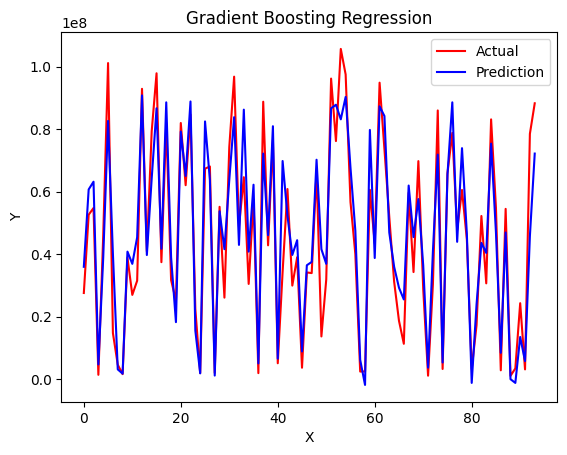

0.8718233271258429

In [541]:
gradient_boosting_model=GradientBoostingRegressor(n_estimators=207,loss="squared_error",alpha=0.01)
gradient_boosting_model.fit(x_train,y_train)
gradient_boosting_predict=gradient_boosting_model.predict(x_test)

plt.plot( y_test, label='Actual', color='red')
plt.plot(gradient_boosting_predict, label='Prediction', color='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Gradient Boosting Regression')
plt.show()
r2_score(y_test,gradient_boosting_predict)

In [542]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=x_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [543]:
model = create_model()
print(model.summary())

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_151 (Dense)           (None, 8)                 32        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_152 (Dense)           (None, 1)                 9         
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [544]:
# predictions = model.predict(x_test)
# plt.plot( y_test, label='Test Data', color='red')
# plt.plot(predictions, label='Prediction', color='blue')

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.title('Neural Network Regression')
# plt.show()